<p><a name="numpy"></a></p>
# Machine Learning Project (NYCDSA)
## House Prices: Advanced Regression Techniques
- [Kaggle-house-prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques#evaluation)
                        

- **Team**
 - Boost5 (Zhe Yang, Yinan Jiang, Kevin Hwang, Hua Yang, Donghyun Kang)
- **Goal**
 - It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 
- **Metric**
 - Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

## 1. Import library

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt  # Matlab-style plotting
import math
import re
import seaborn as sns
#color = sns.color_palette()
#sns.set_style('darkgrid')

from scipy import stats
from scipy.stats import norm, skew #for some statistics
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split

import warnings
#warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

%matplotlib inline
plt.style.use('ggplot')

## 2. Loading data from csv

In [2]:
pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x)) #Limiting floats output to 4 decimal points
#pd.set_eng_float_format(accuracy=4) # how float is formatted in DataFrame
pd.set_option('display.max_columns', 85)
pd.set_option('display.max_rows', 85)

## load data
house = pd.read_csv('./dataset/train.csv', index_col='Id')
house_test = pd.read_csv('./dataset/test.csv', index_col='Id')
#print(house.columns)
SalePrice_org = house.SalePrice
house.SalePrice = house.SalePrice.apply(np.log) # the logarithm with base e
print(house.shape)
print(house_test.shape)
house.describe(include='all')

(1460, 80)
(1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.0000,1460,1201.0000,1460.0000,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460.0000,1460.0000,1460.0000,1460.0000,1460,1460,1460,1460,1452,1452.0000,1460,1460,1460,1423,1423,1422,1423,1460.0000,1422,1460.0000,1460.0000,1460.0000,1460,1460,1460,1459,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460,1460.0000,1460,1460.0000,770,1379,1379.0000,1379,1460.0000,1460.0000,1379,1379,1460,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,7,281,54,1460.0000,1460.0000,1460.0000,1460,1460,1460.0000
unique,nan,5,nan,nan,2,2,4,4,2,5,3,25,9,8,5,8,nan,nan,nan,nan,6,8,15,16,4,nan,4,5,6,4,4,4,6,nan,6,nan,nan,nan,6,5,2,5,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,4,nan,7,nan,5,6,nan,3,nan,nan,5,5,3,nan,nan,nan,nan,nan,nan,3,4,4,nan,nan,nan,9,6,nan
top,nan,RL,nan,nan,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,nan,nan,nan,nan,Gable,CompShg,VinylSd,VinylSd,None,nan,TA,TA,PConc,TA,TA,No,Unf,nan,Unf,nan,nan,nan,GasA,Ex,Y,SBrkr,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,TA,nan,Typ,nan,Gd,Attchd,nan,Unf,nan,nan,TA,TA,Y,nan,nan,nan,nan,nan,nan,Gd,MnPrv,Shed,nan,nan,nan,WD,Normal,nan
freq,nan,1151,nan,nan,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,nan,nan,nan,nan,1141,1434,515,504,864,nan,906,1282,647,649,1311,953,430,nan,1256,nan,nan,nan,1428,741,1365,1334,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,735,nan,1360,nan,380,870,nan,605,nan,nan,1311,1326,1340,nan,nan,nan,nan,nan,nan,3,157,49,nan,nan,nan,1267,1198,nan
mean,56.8973,NaN,70.0500,10516.8281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0993,5.5753,1971.2678,1984.8658,NaN,NaN,NaN,NaN,NaN,103.6853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443.6397,NaN,46.5493,567.2404,1057.4295,NaN,NaN,NaN,NaN,1162.6267,346.9925,5.8445,1515.4637,0.4253,0.0575,1.5651,0.3829,2.8664,1.0466,NaN,6.5178,NaN,0.6130,NaN,NaN,1978.5062,NaN,1.7671,472.9801,NaN,NaN,NaN,94.2445,46.6603,21.9541,3.4096,15.0610,2.7589,NaN,NaN,NaN,43.4890,6.3219,2007.8158,NaN,NaN,12.0241
std,42.3006,NaN,24.2848,9981.2649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.3830,1.1128,30.2029,20.6454,NaN,NaN,NaN,NaN,NaN,181.0662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.0981,NaN,161.3193,441.8670,438.7053,NaN,NaN,NaN,NaN,386.5877,436.5284,48.6231,525.4804,0.5189,0.2388,0.5509,0.5029,0.8158,0.2203,NaN,1.6254,NaN,0.6447,NaN,NaN,24.6897,NaN,0.7473,213.8048,NaN,NaN,NaN,125.3388,66.2560,61.1191,29.3173,55.7574,40.1773,NaN,NaN,NaN,496.1230,2.7036,1.3281,NaN,NaN,0.3995
min,20.0000,NaN,21.0000,1300.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0000,1.0000,1872.0000,1950.0000,NaN,NaN,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,NaN,0.0000,0.0000,0.0000,NaN,NaN,NaN,NaN,334.0000,0.0000,0.0000,334.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,2.0000,NaN,0.0000,NaN,NaN,1900.0000,NaN,0.0000,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,1.0000,2006.0000,NaN,NaN,10.4602
25%,20.0000,NaN,59.0000,7553.5000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0000,5.0000,1954.0000,1967.0000,NaN,NaN,NaN,NaN,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0000,NaN,0.0000,223.0000,795.7500,NaN,NaN,Na

### 2.1 Numerical Data

In [3]:
h_num = house.describe(include=[np.number])
print(h_num.shape)
h_num

(8, 37)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.0000,1201.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1452.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1379.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000
mean,56.8973,70.0500,10516.8281,6.0993,5.5753,1971.2678,1984.8658,103.6853,443.6397,46.5493,567.2404,1057.4295,1162.6267,346.9925,5.8445,1515.4637,0.4253,0.0575,1.5651,0.3829,2.8664,1.0466,6.5178,0.6130,1978.5062,1.7671,472.9801,94.2445,46.6603,21.9541,3.4096,15.0610,2.7589,43.4890,6.3219,2007.8158,12.0241
std,42.3006,24.2848,9981.2649,1.3830,1.1128,30.2029,20.6454,181.0662,456.0981,161.3193,441.8670,438.7053,386.5877,436.5284,48.6231,525.4804,0.5189,0.2388,0.5509,0.5029,0.8158,0.2203,1.6254,0.6447,24.6897,0.7473,213.8048,125.3388,66.2560,61.1191,29.3173,55.7574,40.1773,496.1230,2.7036,1.3281,0.3995
min,20.0000,21.0000,1300.0000,1.0000,1.0000,1872.0000,1950.0000,0.0000,0.0000,0.0000,0.0000,0.0000,334.0000,0.0000,0.0000,334.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,1900.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,2006.0000,10.4602
25%,20.0000,59.0000,7553.5000,5.0000,5.0000,1954.0000,1967.0000,0.0000,0.0000,0.0000,223.0000,795.7500,882.0000,0.0000,0.0000,1129.5000,0.0000,0.0000,1.0000,0.0000,2.0000,1.0000,5.0000,0.0000,1961.0000,1.0000,334.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.0000,2007.0000,11.7751
50%,50.0000,69.0000,9478.5000,6.0000,5.0000,1973.0000,1994.0000,0.0000,383.5000,0.0000,477.5000,991.5000,1087.0000,0.0000,0.0000,1464.0000,0.0000,0.0000,2.0000,0.0000,3.0000,1.0000,6.0000,1.0000,1980.0000,2.0000,480.0000,0.0000,25.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.0000,2008.0000,12.0015
75%,70.0000,80.0000,11601.5000,7.0000,6.0000,2000.0000,2004.0000,166.0000,712.2500,0.0000,808.0000,1298.2500,1391.2500,728.0000,0.0000,1776.7500,1.0000,0.0000,2.0000,1.0000,3.0000,1.0000,7.0000,1.0000,2002.0000,2.0000,576.0000,168.0000,68.0000,0.0000,0.0000,0.0000,0.0000,0.0000,8.0000,2009.0000,12.2737
max,190.0000,313.0000,215245.0000,10.0000,9.0000,2010.0000,2010.0000,1600.0000,5644.0000,1474.0000,2336.0000,6110.0000,4692.0000,2065.0000,572.0000,5642.0000,3.0000,2.0000,3.0000,2.0000,8.0000,3.0000,14.0000,3.0000,2010.0000,4.0000,1418.0000,857.0000,547.0000,552.0000,508.0000,480.0000,738.0000,15500.0000,12.0000,2010.0000,13.5345


### 2.2 Categorical Data

In [4]:
h_cat = house.describe(include=[np.object])
print(h_cat.shape)
h_cat

(4, 43)


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


## 3. SalePrice Analysis

### 3.1 Descriptive Statistics Summary

In [5]:
SP = pd.concat([SalePrice_org, house.SalePrice], axis=1, keys=['SalePrice', 'SalePrice(log)'])
SP.describe()

,SalePrice,SalePrice(log)
count,1460.0000,1460.0000
mean,180921.1959,12.0241
std,79442.5029,0.3995
min,34900.0000,10.4602
25%,129975.0000,11.7751
50%,163000.0000,12.0015
75%,214000.0000,12.2737
max,755000.0000,13.5345


### 3.2 Histogram and Distribution

In [6]:
mu, sigma = norm.fit(SP['SalePrice'])
print( 'SalePrice(raw) \t\t : mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))
mu2, sigma2 = norm.fit(house['SalePrice'])
print( 'SalePrice(log-normal) \t : mu = {:.2f} and sigma = {:.2f}'.format(mu2, sigma2))

SalePrice(raw) 		 : mu = 180921.20 and sigma = 79415.29
SalePrice(log-normal) 	 : mu = 12.02 and sigma = 0.40


- Raw SalePrice Distribution

In [7]:
SP['SalePrice'].describe()

count     1460.0000
mean    180921.1959
std      79442.5029
min      34900.0000
25%     129975.0000
50%     163000.0000
75%     214000.0000
max     755000.0000
Name: SalePrice, dtype: float64

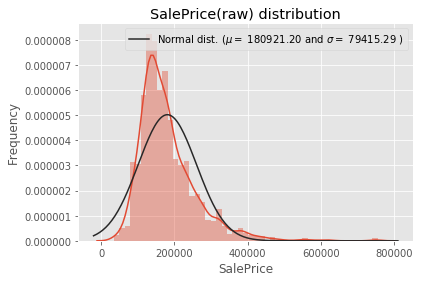

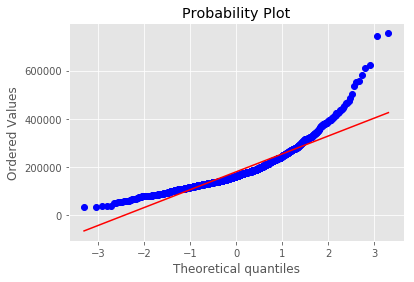

In [8]:
sns.distplot(SP['SalePrice'] , fit=norm);
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice(raw) distribution')

fig = plt.figure()
res = stats.probplot(SP['SalePrice'], plot=plt)
plt.show()

-> With this information we can see that the prices are skewed right and some outliers lies above ~500,000. We will eventually want to get rid of the them to get a normal distribution of the independent variable (`SalePrice`) for machine learning.

- Log normal SalePrice Distribution

In [9]:
SP['SalePrice(log)'].describe()

count   1460.0000
mean      12.0241
std        0.3995
min       10.4602
25%       11.7751
50%       12.0015
75%       12.2737
max       13.5345
Name: SalePrice(log), dtype: float64

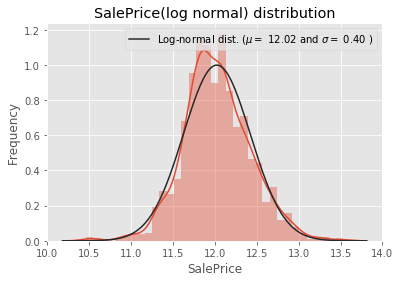

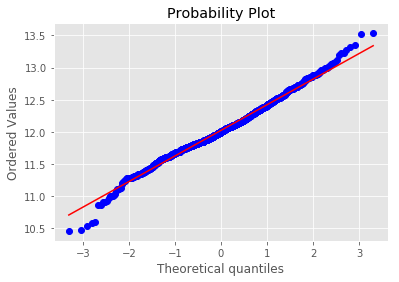

In [10]:
sns.distplot(house.SalePrice , fit=norm); #house.SalePrice = house.SalePrice.apply(np.log) # the logarithm with base e
#sns.distplot(np.log1p(SP['SalePrice']) , fit=norm);
plt.legend(['Log-normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu2, sigma2)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice(log normal) distribution')

fig = plt.figure()
res = stats.probplot(house['SalePrice'], plot=plt)
plt.show()

## 4. Data Categorization & Cleaning

### 4.1 Missing Data Analysis

- Checking for Missing Data

In [11]:
#Checking for missing data
NAs = pd.concat([house.isnull().sum(), house_test.isnull().sum()], axis=1, keys=['Train', 'Test'])
NAs[NAs.sum(axis=1) > 0].T

,Alley,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,Electrical,Exterior1st,Exterior2nd,Fence,FireplaceQu,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,KitchenQual,LotFrontage,MSZoning,MasVnrArea,MasVnrType,MiscFeature,PoolQC,SaleType,TotalBsmtSF,Utilities
Train,1369.0000,37.0000,38.0000,0.0000,0.0000,37.0000,38.0000,0.0000,0.0000,37.0000,0.0000,1.0000,0.0000,0.0000,1179.0000,690.0000,0.0000,0.0000,0.0000,81.0000,81.0000,81.0000,81.0000,81.0000,0.0000,259.0000,0.0000,8.0000,8.0000,1406.0000,1453.0000,0.0000,0.0000,0.0000
Test,1352.0000,45.0000,44.0000,1.0000,1.0000,42.0000,42.0000,2.0000,2.0000,44.0000,1.0000,0.0000,1.0000,1.0000,1169.0000,730.0000,2.0000,1.0000,1.0000,78.0000,78.0000,78.0000,76.0000,78.0000,1.0000,227.0000,4.0000,15.0000,16.0000,1408.0000,1456.0000,1.0000,1.0000,2.0000


- Missing list for numerical

In [12]:
#### To find missing list for numerical
h_num_wo_sales = h_num.drop('SalePrice', axis=1)
tr_num = house[h_num_wo_sales.columns]
ts_num = house_test[h_num_wo_sales.columns]
NAs_num = pd.concat([tr_num.isnull().sum(), ts_num.isnull().sum()], axis=1, keys=['Train', 'Test'])
NAs_num_idx = (NAs_num[NAs_num.sum(axis=1) > 0].index)
print(NAs_num_idx)
NAs_num[NAs_num.sum(axis=1) > 0].T

Index(['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt',
       'GarageCars', 'GarageArea'],
      dtype='object')


,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageYrBlt,GarageCars,GarageArea
Train,259,8,0,0,0,0,0,0,81,0,0
Test,227,15,1,1,1,1,2,2,78,1,1


- Missing list for categorical

In [13]:
#### To find missing list for category
tr_cat = house[h_cat.columns]
ts_cat = house_test[h_cat.columns]
NAs_cat = pd.concat([tr_cat.isnull().sum(), ts_cat.isnull().sum()], axis=1, keys=['Train', 'Test'])
NAs_cat_idx = (NAs_cat[NAs_cat.sum(axis=1) > 0].index)
print('Numerical(train_set) : ',len(tr_num.columns))
print('Categorical(train_set) : ',len(tr_cat.columns))
print(NAs_cat_idx)
NAs_cat[NAs_cat.sum(axis=1) > 0].T

Numerical(train_set) :  36
Categorical(train_set) :  43
Index(['MSZoning', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PoolQC', 'Fence', 'MiscFeature', 'SaleType'],
      dtype='object')


,MSZoning,Alley,Utilities,Exterior1st,Exterior2nd,MasVnrType,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature,SaleType
Train,0,1369,0,0,0,8,37,37,38,37,38,1,0,0,690,81,81,81,81,1453,1179,1406,0
Test,4,1352,2,1,1,16,44,45,44,42,42,0,1,2,730,76,78,78,78,1456,1169,1408,1


### 4.2 Impute Missing list

In [14]:
from preprocess import impute
tr_imp = impute(house)
ts_imp = impute(house_test)
NAs = pd.concat([tr_imp.isnull().sum(), ts_imp.isnull().sum()], axis=1, keys=['Train', 'Test'])
NAs[NAs.sum(axis=1) > 0].T

""
Train
Test


In [15]:
print(tr_imp.shape)

print('Numerical(train_set_imputed) : ', len(tr_imp.describe(include=[np.number]).columns))
print('Categorical(train_set_imputed) : ', len(tr_imp.describe(include=[np.object]).columns))
print("Categorical(43->42) <-- df = df.drop(['Utilities'], axis=1)'")

tr_imp.describe(include=[np.number])

(1460, 79)
Numerical(train_set_imputed) :  37
Categorical(train_set_imputed) :  42
Categorical(43->42) <-- df = df.drop(['Utilities'], axis=1)'


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000,1460.0000
mean,56.8973,70.1997,10516.8281,6.0993,5.5753,1971.2678,1984.8658,103.1171,443.6397,46.5493,567.2404,1057.4295,1162.6267,346.9925,5.8445,1515.4637,0.4253,0.0575,1.5651,0.3829,2.8664,1.0466,6.5178,0.6130,1868.7397,1.7671,472.9801,94.2445,46.6603,21.9541,3.4096,15.0610,2.7589,43.4890,6.3219,2007.8158,12.0241
std,42.3006,22.4319,9981.2649,1.3830,1.1128,30.2029,20.6454,180.7314,456.0981,161.3193,441.8670,438.7053,386.5877,436.5284,48.6231,525.4804,0.5189,0.2388,0.5509,0.5029,0.8158,0.2203,1.6254,0.6447,453.6973,0.7473,213.8048,125.3388,66.2560,61.1191,29.3173,55.7574,40.1773,496.1230,2.7036,1.3281,0.3995
min,20.0000,21.0000,1300.0000,1.0000,1.0000,1872.0000,1950.0000,0.0000,0.0000,0.0000,0.0000,0.0000,334.0000,0.0000,0.0000,334.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,2006.0000,10.4602
25%,20.0000,60.0000,7553.5000,5.0000,5.0000,1954.0000,1967.0000,0.0000,0.0000,0.0000,223.0000,795.7500,882.0000,0.0000,0.0000,1129.5000,0.0000,0.0000,1.0000,0.0000,2.0000,1.0000,5.0000,0.0000,1958.0000,1.0000,334.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,5.0000,2007.0000,11.7751
50%,50.0000,70.0000,9478.5000,6.0000,5.0000,1973.0000,1994.0000,0.0000,383.5000,0.0000,477.5000,991.5000,1087.0000,0.0000,0.0000,1464.0000,0.0000,0.0000,2.0000,0.0000,3.0000,1.0000,6.0000,1.0000,1977.0000,2.0000,480.0000,0.0000,25.0000,0.0000,0.0000,0.0000,0.0000,0.0000,6.0000,2008.0000,12.0015
75%,70.0000,80.0000,11601.5000,7.0000,6.0000,2000.0000,2004.0000,164.2500,712.2500,0.0000,808.0000,1298.2500,1391.2500,728.0000,0.0000,1776.7500,1.0000,0.0000,2.0000,1.0000,3.0000,1.0000,7.0000,1.0000,2001.0000,2.0000,576.0000,168.0000,68.0000,0.0000,0.0000,0.0000,0.0000,0.0000,8.0000,2009.0000,12.2737
max,190.0000,313.0000,215245.0000,10.0000,9.0000,2010.0000,2010.0000,1600.0000,5644.0000,1474.0000,2336.0000,6110.0000,4692.0000,2065.0000,572.0000,5642.0000,3.0000,2.0000,3.0000,2.0000,8.0000,3.0000,14.0000,3.0000,2010.0000,4.0000,1418.0000,857.0000,547.0000,552.0000,508.0000,480.0000,738.0000,15500.0000,12.0000,2010.0000,13.5345


In [16]:
tr_imp.describe(include=[np.object])
#tr_imp.describe(include=[np.object]).columns

,MSZoning,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
unique,5,2,3,4,4,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,5,5,5,7,7,6,5,2,5,4,7,6,7,4,6,6,3,4,5,5,9,6
top,RL,Pave,None,Reg,Lvl,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,None,Attchd,Unf,TA,TA,Y,None,None,None,WD,Normal
freq,1151,1454,1369,925,1311,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,872,906,1282,647,649,1311,953,430,1256,1428,741,1365,1335,735,1360,690,870,605,1311,1326,1340,1453,1179,1406,1267,1198


- level capturing from datadescription file

In [17]:
# data_description_mod.txt --> misprinted things corrected version from original 
with open('./dataset/data_description_mod.txt', 'r') as file:
    lines_level = file.readlines()
    
feature = ''
levels = {}
level = ''

for line in lines_level:
    if (re.findall(': ', line)) and (not re.findall('story:', line)):
        feature = re.split(':', line)[0]
        levels[feature] = []
    else:
        if line != '\n':
            level = re.split('\t', line)[0].strip()
            if level != '': levels[feature].append(level)
levels['Id'] = []
levels['SalePrice'] = []
print(len(levels.items()))
#levels

81


- Nominal and Ordinal features

In [18]:
# find nominal and ordinal
with open('./dataset/DataDocumentation.txt', 'r',encoding='cp1252') as file:
    lines = file.readlines()
    
nom_lines = []
ord_lines = []
for line in lines:
    if re.findall('(Nominal)', line):
        nom_lines.append(re.sub(' ', '', re.split('\(Nominal\)', line)[0].strip()))
    elif re.findall('(Ordinal)', line):
        ord_lines.append(re.sub(' ', '', re.split('\(Ordinal\)', line)[0].strip()))
print(len(nom_lines), nom_lines)
print(len(ord_lines), ord_lines)

23 ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1', 'Exterior2', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition']
23 ['LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence']


### 4.3 Train Set : Transforming features to its real type

In [19]:
# Transforming features to its real type
def my_cat(col, levels, ord_lines):
    if not not levels[col.name]: 
        if col.name in ord_lines:
            temp = pd.Categorical(list(col.astype('str')), ordered=True, categories=levels[col.name][::-1])
            temp.name = col.name
            return temp
        else:
            temp = pd.Categorical(list(col.astype('str')), categories=levels[col.name][::-1])
            temp.name = col.name
            return temp
    else:
        return col

tr_impTr = tr_imp.copy(deep=True)
for col in tr_impTr:
    tr_impTr[col] = my_cat(tr_impTr[col], levels, ord_lines)

print('<<< train_set(imputed) status >>>'.upper())
print('Original features in csv file \t: ', len(house.columns))
print('-'*65)
print('After Imputation \t\t: ', len(tr_imp.columns), '(Utility feat. removed)' )
print('-'*65)
print('Before Transform/Numerical \t: ', len(tr_imp.describe(include=[np.number]).columns))
print('Before Transform/Categorical \t: ', len(tr_imp.describe(include=[np.object]).columns))
print('-'*65)
tmpN = len(tr_impTr.describe(include=[np.number]).columns) - len(tr_imp.describe(include=[np.number]).columns)
tmpC = len(tr_impTr.describe(exclude=[np.number]).columns)- len(tr_imp.describe(include=[np.object]).columns)
print('After  Transform/Numerical \t: ', len(tr_impTr.describe(include=[np.number]).columns), "(",tmpN, ")")
print('After  Transform/Categorical \t: ', len(tr_impTr.describe(exclude=[np.number]).columns), "(",tmpC, ")")
print('-'*65)
print("42 -> 45: 'MSSubClass', 'OverallQual', 'OverallCond' Added from Numeric to Ordianl")
tr_impTr.describe(exclude=[np.number])

<<< TRAIN_SET(IMPUTED) STATUS >>>
Original features in csv file 	:  80
-----------------------------------------------------------------
After Imputation 		:  79 (Utility feat. removed)
-----------------------------------------------------------------
Before Transform/Numerical 	:  37
Before Transform/Categorical 	:  42
-----------------------------------------------------------------
After  Transform/Numerical 	:  34 ( -3 )
After  Transform/Categorical 	:  45 ( 3 )
-----------------------------------------------------------------
42 -> 45: 'MSSubClass', 'OverallQual', 'OverallCond' Added from Numeric to Ordianl


,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1460,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,15,5,2,2,4,4,5,3,25,9,8,5,8,10,9,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,20,RL,Pave,Grvl,Reg,Lvl,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,5,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,536,1151,1454,50,925,1311,1052,1382,225,1260,1445,1220,726,397,821,1141,1434,515,504,872,906,1282,647,649,1311,953,430,1256,1428,741,1365,1335,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


### 4.4 Test Set : Transforming features to its real type

In [20]:
# Same Transform to test data
ts_impTr = ts_imp.copy(deep=True)
for col in ts_imp:
    ts_impTr[col] = my_cat(ts_imp[col], levels, ord_lines)
    
print('<<< test_set(imputed) status >>>'.upper())
print('Original features in csv file \t: ', len(house_test.columns), '(No SalePrice column)')
print('-'*65)
print('After Imputation \t\t: ', len(ts_imp.columns), '(Utility column removed)' )
print('-'*65)
print('Before Transform/Numerical \t: ', len(ts_imp.describe(include=[np.number]).columns))
print('Before Transform/Categorical \t: ', len(ts_imp.describe(include=[np.object]).columns))
print('-'*65)
tmpN = len(ts_impTr.describe(include=[np.number]).columns) - len(ts_imp.describe(include=[np.number]).columns)
tmpC = len(ts_impTr.describe(exclude=[np.number]).columns)- len(ts_imp.describe(include=[np.object]).columns)
print('After Transform/Numerical \t: ', len(ts_impTr.describe(include=[np.number]).columns), "(",tmpN, ")")
print('After Transform/Categorical \t: ', len(ts_impTr.describe(exclude=[np.number]).columns), "(",tmpC, ")")
print('-'*65)
print("42 -> 45: 'MSSubClass', 'OverallQual', 'OverallCond' Added from Numeric to Ordianl")

ts_impTr.describe(exclude=[np.number])

<<< TEST_SET(IMPUTED) STATUS >>>
Original features in csv file 	:  79 (No SalePrice column)
-----------------------------------------------------------------
After Imputation 		:  78 (Utility column removed)
-----------------------------------------------------------------
Before Transform/Numerical 	:  36
Before Transform/Categorical 	:  42
-----------------------------------------------------------------
After Transform/Numerical 	:  33 ( -3 )
After Transform/Categorical 	:  45 ( 3 )
-----------------------------------------------------------------
42 -> 45: 'MSSubClass', 'OverallQual', 'OverallCond' Added from Numeric to Ordianl


,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1459,1459,1459,107,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1459,1415,1414,1415,1417,1417,1459,1459,1459,1459,1459,1459,729,1383,1381,1381,1381,1459,3,290,51,1459,1459
unique,16,5,2,2,4,4,5,3,25,9,5,5,7,10,9,6,4,13,15,4,4,5,6,4,4,4,6,6,4,5,2,4,4,7,5,6,3,4,5,3,2,4,3,9,6
top,20,RL,Pave,Grvl,Reg,Lvl,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,5,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Ex,MnPrv,Shed,WD,Normal
freq,543,1118,1453,70,934,1311,1081,1396,218,1251,1444,1205,745,428,824,1169,1442,511,511,894,892,1256,661,634,1295,951,431,1237,1446,752,1358,1337,758,1359,364,853,625,1293,1328,1301,2,172,46,1259,1204


- df 'house' by concat b/w train_set and test_set together

In [21]:
# As of now, deal with df 'house' by concat b/w train_set and test_set together
price = house.SalePrice
print('Null in SalePrice list : ', price.isnull().sum())
house_all = pd.concat([tr_impTr.iloc[:, :-1], ts_impTr], ignore_index = True) # tr_impTr.drop('SalePrice', axis=1)
print(house_all.shape)
print("cf) Zhe's cleaning data size is (2919,79), 1 column is Utility which I dropped it, refer to preprocess.py ")
house_all.head(5)

Null in SalePrice list :  0
(2919, 78)
cf) Zhe's cleaning data size is (2919,79), 1 column is Utility which I dropped it, refer to preprocess.py 


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0000,8450,Pave,NaN,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0000,Gd,TA,PConc,Gd,TA,No,GLQ,706.0000,Unf,0.0000,150.0000,856.0000,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0000,0.0000,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0000,RFn,2.0000,548.0000,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0000,9600,Pave,NaN,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0000,Unf,0.0000,284.0000,1262.0000,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0000,1.0000,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0000,RFn,2.0000,460.0000,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0000,11250,Pave,NaN,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0000,Unf,0.0000,434.0000,920.0000,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0000,0.0000,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0000,RFn,2.0000,608.0000,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0000,9550,Pave,NaN,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0000,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0000,Unf,0.0000,540.0000,756.0000,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0000,0.0000,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0000,Unf,3.0000,642.0000,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0000,14260,Pave,NaN,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0000,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0000,Unf,0.0000,490.0000,1145.0000,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0000,0.0000,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0000,RFn,3.0000,836.0000,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [22]:
# Looking over the below ordinal data
print(levels['OverallQual'][::-1])
print(levels['ExterQual'][::-1])
print(levels['BsmtQual'][::-1])
print(levels['KitchenQual'][::-1])
print(levels['GarageFinish'][::-1])
print(levels['FireplaceQu'][::-1])
print(levels['HeatingQC'][::-1])

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
['Po', 'Fa', 'TA', 'Gd', 'Ex']
['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
['Po', 'Fa', 'TA', 'Gd', 'Ex']
['NA', 'Unf', 'RFn', 'Fin']
['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
['Po', 'Fa', 'TA', 'Gd', 'Ex']


### 4.5 Convert the value of each ordinal data into relative Number

In [23]:
#{'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}.get('Po', 0)
# Convert the value of each ordinal data into relative Number
house = house_all.copy()
print('ex)', house.BsmtQual[0], ' -> ', end='')
if(0):
    house['ExterQual'] = house['ExterQual'].map(lambda x: {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}.get(x, 0))
    house['BsmtQual'] = house['BsmtQual'].map(lambda x: {'NA':0,'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}.get(x, 0))
    house['KitchenQual'] = house['KitchenQual'].map(lambda x: {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}.get(x, 0))
    house['GarageFinish'] = house['GarageFinish'].map(lambda x: {'NA':0, 'Unf':1, 'RFn':2, 'Fin':3}.get(x, 0))
    house['FireplaceQu'] = house['FireplaceQu'].map(lambda x: {'NA':0,'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}.get(x, 0))
    house['HeatingQC'] = house['HeatingQC'].map(lambda x: {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}.get(x, 0))
else:
    house['ExterQual'] = house['ExterQual'].map(lambda x: {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}.get(x, 0))
    house['BsmtQual'] = house['BsmtQual'].map(lambda x: {'NA':1,'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6}.get(x, 0))
    house['KitchenQual'] = house['KitchenQual'].map(lambda x: {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}.get(x, 0))
    house['GarageFinish'] = house['GarageFinish'].map(lambda x: {'NA':1, 'Unf':2, 'RFn':3, 'Fin':4}.get(x, 0))
    house['FireplaceQu'] = house['FireplaceQu'].map(lambda x: {'NA':1,'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6}.get(x, 0))
    house['HeatingQC'] = house['HeatingQC'].map(lambda x: {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}.get(x, 0))
print(house.BsmtQual[0])

ex) Gd  -> 5.0


In [24]:
#house.info()
house.describe(include=[np.number]).info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, count to max
Data columns (total 33 columns):
LotFrontage      8 non-null float64
LotArea          8 non-null float64
YearBuilt        8 non-null float64
YearRemodAdd     8 non-null float64
MasVnrArea       8 non-null float64
BsmtFinSF1       8 non-null float64
BsmtFinSF2       8 non-null float64
BsmtUnfSF        8 non-null float64
TotalBsmtSF      8 non-null float64
1stFlrSF         8 non-null float64
2ndFlrSF         8 non-null float64
LowQualFinSF     8 non-null float64
GrLivArea        8 non-null float64
BsmtFullBath     8 non-null float64
BsmtHalfBath     8 non-null float64
FullBath         8 non-null float64
HalfBath         8 non-null float64
BedroomAbvGr     8 non-null float64
KitchenAbvGr     8 non-null float64
TotRmsAbvGrd     8 non-null float64
Fireplaces       8 non-null float64
GarageYrBlt      8 non-null float64
GarageCars       8 non-null float64
GarageArea       8 non-null float64
WoodDeckSF       8 non-null float6

In [25]:
print('-> Type of the converted features are NOT A NUMBER, even these seem to int64')
house.describe(exclude=[np.number]).info()

-> Type of the converted features are NOT A NUMBER, even these seem to int64
<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, count to freq
Data columns (total 45 columns):
MSSubClass       4 non-null object
MSZoning         4 non-null object
Street           4 non-null object
Alley            4 non-null object
LotShape         4 non-null object
LandContour      4 non-null object
LotConfig        4 non-null object
LandSlope        4 non-null object
Neighborhood     4 non-null object
Condition1       4 non-null object
Condition2       4 non-null object
BldgType         4 non-null object
HouseStyle       4 non-null object
OverallQual      4 non-null object
OverallCond      4 non-null object
RoofStyle        4 non-null object
RoofMatl         4 non-null object
Exterior1st      4 non-null object
Exterior2nd      4 non-null object
MasVnrType       4 non-null object
ExterQual        4 non-null int64
ExterCond        4 non-null object
Foundation       4 non-null object
BsmtQual        

In [26]:
# Just comparison
print('house.YrSold.dtypes : ', house.YrSold.dtypes)
print('house.BsmtQual.dtypes : ', house.BsmtQual.dtypes)
house.select_dtypes(include=['category']).columns

house.YrSold.dtypes :  int64
house.BsmtQual.dtypes :  category


Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

- Correct type of converted ordinal data as Numeric

In [27]:
# Correct type of converted ordinal data as Numeric
#house['OverallQual'] = pd.to_numeric(house['OverallQual'])
house['ExterQual'] = pd.to_numeric(house['ExterQual'])
house['BsmtQual'] = pd.to_numeric(house['BsmtQual'])
house['KitchenQual'] = pd.to_numeric(house['KitchenQual'])
house['GarageFinish'] = pd.to_numeric(house['GarageFinish'])
house['FireplaceQu'] = pd.to_numeric(house['FireplaceQu'])
house['HeatingQC'] = pd.to_numeric(house['HeatingQC'])

In [28]:
# Check Again
for col in ['ExterQual', 'BsmtQual', 'KitchenQual', 'GarageFinish', 'FireplaceQu', 'HeatingQC']:
    print('house.', col, '.dtypes : ', house[col].dtypes)

house. ExterQual .dtypes :  int64
house. BsmtQual .dtypes :  float64
house. KitchenQual .dtypes :  int64
house. GarageFinish .dtypes :  float64
house. FireplaceQu .dtypes :  float64
house. HeatingQC .dtypes :  int64


In [145]:
numeric_cols = house.describe(include=[np.number]).columns

from fancyimpute import KNN
house[numeric_cols] = KNN(k = int(math.sqrt(house.shape[0]))).complete(house[numeric_cols])

Imputing row 1/2919 with 1 missing, elapsed time: 3.038
Imputing row 101/2919 with 0 missing, elapsed time: 3.042
Imputing row 201/2919 with 1 missing, elapsed time: 3.045
Imputing row 301/2919 with 0 missing, elapsed time: 3.049
Imputing row 401/2919 with 0 missing, elapsed time: 3.052
Imputing row 501/2919 with 1 missing, elapsed time: 3.055
Imputing row 601/2919 with 0 missing, elapsed time: 3.058
Imputing row 701/2919 with 0 missing, elapsed time: 3.061
Imputing row 801/2919 with 1 missing, elapsed time: 3.065
Imputing row 901/2919 with 1 missing, elapsed time: 3.069
Imputing row 1001/2919 with 2 missing, elapsed time: 3.072
Imputing row 1101/2919 with 1 missing, elapsed time: 3.076
Imputing row 1201/2919 with 1 missing, elapsed time: 3.079
Imputing row 1301/2919 with 0 missing, elapsed time: 3.083
Imputing row 1401/2919 with 0 missing, elapsed time: 3.086
Imputing row 1501/2919 with 1 missing, elapsed time: 3.089
Imputing row 1601/2919 with 1 missing, elapsed time: 3.093
Imputing 

In [146]:
train_clean =  house.iloc[:1460,:]
train_clean['SalePrice'] = price.values
print(train_clean.shape)
train_clean.head(5)

(1460, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0000,8450.0000,Pave,NaN,Reg,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003.0000,2003.0000,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0000,4.0000,TA,PConc,5.0000,TA,No,GLQ,706.0000,Unf,0.0000,150.0000,856.0000,GasA,5.0000,Y,SBrkr,856.0000,854.0000,0.0000,1710.0000,1.0000,0.0000,2.0000,1.0000,3.0000,1.0000,4.0000,8.0000,Typ,0.0000,4.2691,Attchd,2003.0000,3.0000,2.0000,548.0000,TA,TA,Y,0.0000,61.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,2.0000,2008.0000,WD,Normal,12.2477
1,20,RL,80.0000,9600.0000,Pave,NaN,Reg,Lvl,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976.0000,1976.0000,Gable,CompShg,MetalSd,MetalSd,None,0.0000,3.0000,TA,CBlock,5.0000,TA,Gd,ALQ,978.0000,Unf,0.0000,284.0000,1262.0000,GasA,5.0000,Y,SBrkr,1262.0000,0.0000,0.0000,1262.0000,0.0000,1.0000,2.0000,0.0000,3.0000,1.0000,3.0000,6.0000,Typ,1.0000,4.0000,Attchd,1976.0000,3.0000,2.0000,460.0000,TA,TA,Y,298.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,5.0000,2007.0000,WD,Normal,12.1090
2,60,RL,68.0000,11250.0000,Pave,NaN,IR1,Lvl,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001.0000,2002.0000,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0000,4.0000,TA,PConc,5.0000,TA,Mn,GLQ,486.0000,Unf,0.0000,434.0000,920.0000,GasA,5.0000,Y,SBrkr,920.0000,866.0000,0.0000,1786.0000,1.0000,0.0000,2.0000,1.0000,3.0000,1.0000,4.0000,6.0000,Typ,1.0000,4.0000,Attchd,2001.0000,3.0000,2.0000,608.0000,TA,TA,Y,0.0000,42.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,9.0000,2008.0000,WD,Normal,12.3172
3,70,RL,60.0000,9550.0000,Pave,NaN,IR1,Lvl,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915.0000,1970.0000,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0000,3.0000,TA,BrkTil,4.0000,Gd,No,ALQ,216.0000,Unf,0.0000,540.0000,756.0000,GasA,4.0000,Y,SBrkr,961.0000,756.0000,0.0000,1717.0000,1.0000,0.0000,1.0000,0.0000,3.0000,1.0000,4.0000,7.0000,Typ,1.0000,5.0000,Detchd,1998.0000,2.0000,3.0000,642.0000,TA,TA,Y,0.0000,35.0000,272.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,2.0000,2006.0000,WD,Abnorml,11.8494
4,60,RL,84.0000,14260.0000,Pave,NaN,IR1,Lvl,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000.0000,2000.0000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0000,4.0000,TA,PConc,5.0000,TA,Av,GLQ,655.0000,Unf,0.0000,490.0000,1145.0000,GasA,5.0000,Y,SBrkr,1145.0000,1053.0000,0.0000,2198.0000,1.0000,0.0000,2.0000,1.0000,4.0000,1.0000,4.0000,9.0000,Typ,1.0000,4.0000,Attchd,2000.0000,3.0000,3.0000,836.0000,TA,TA,Y,192.0000,84.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,0.0000,12.0000,2008.0000,WD,Normal,12.4292


In [147]:
# Only for check fancyimpute done well !!
train_clean.GarageFinish[train_clean.GarageFinish.isnull()]

Series([], Name: GarageFinish, dtype: float64)

## 5. Data (Feature) Analysis

### 5.1 Numerical features vs. SalePrice

In [148]:
df_numerical = train_clean.select_dtypes(include=['number'])
df_numerical.columns

Index(['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'ExterQual', 'BsmtQual', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'HeatingQC', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

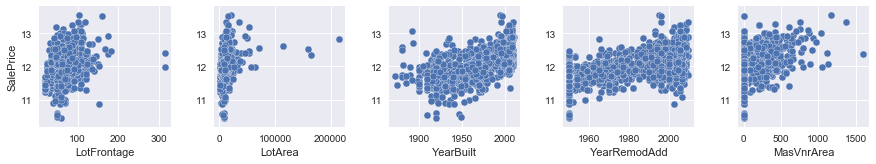

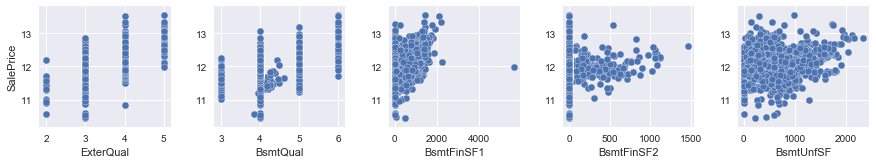

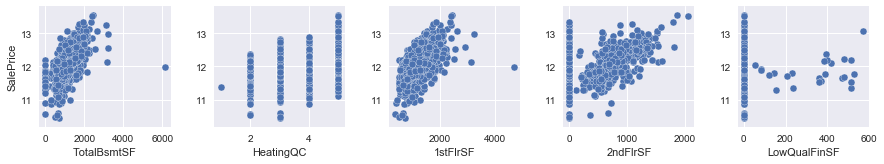

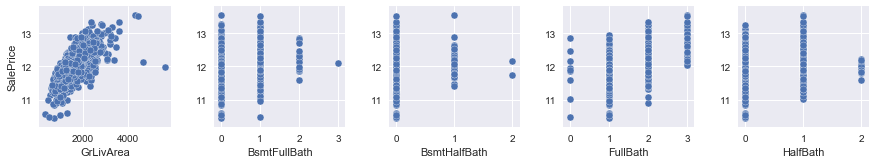

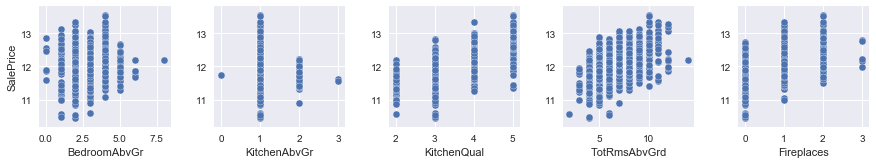

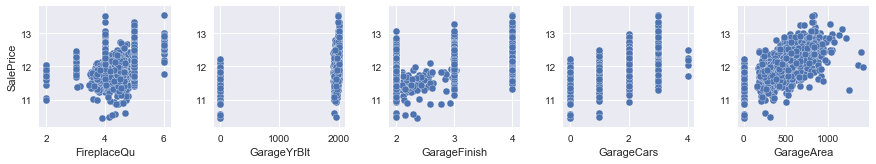

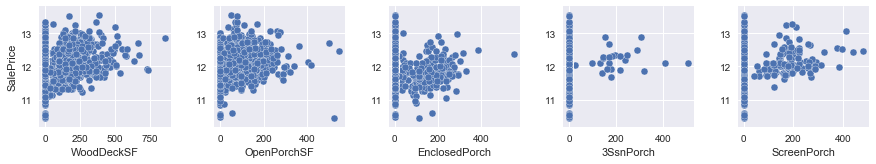

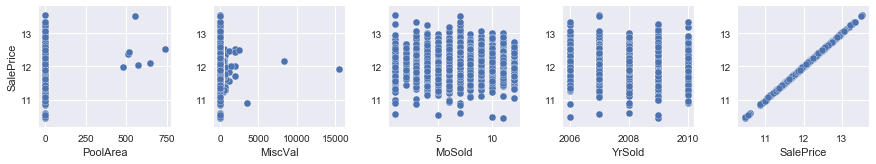

In [149]:
for i in range(0, len(df_numerical.columns), 5):
    sns.pairplot(data=df_numerical,
                x_vars=df_numerical.columns[i:i+5],
                y_vars=['SalePrice'])

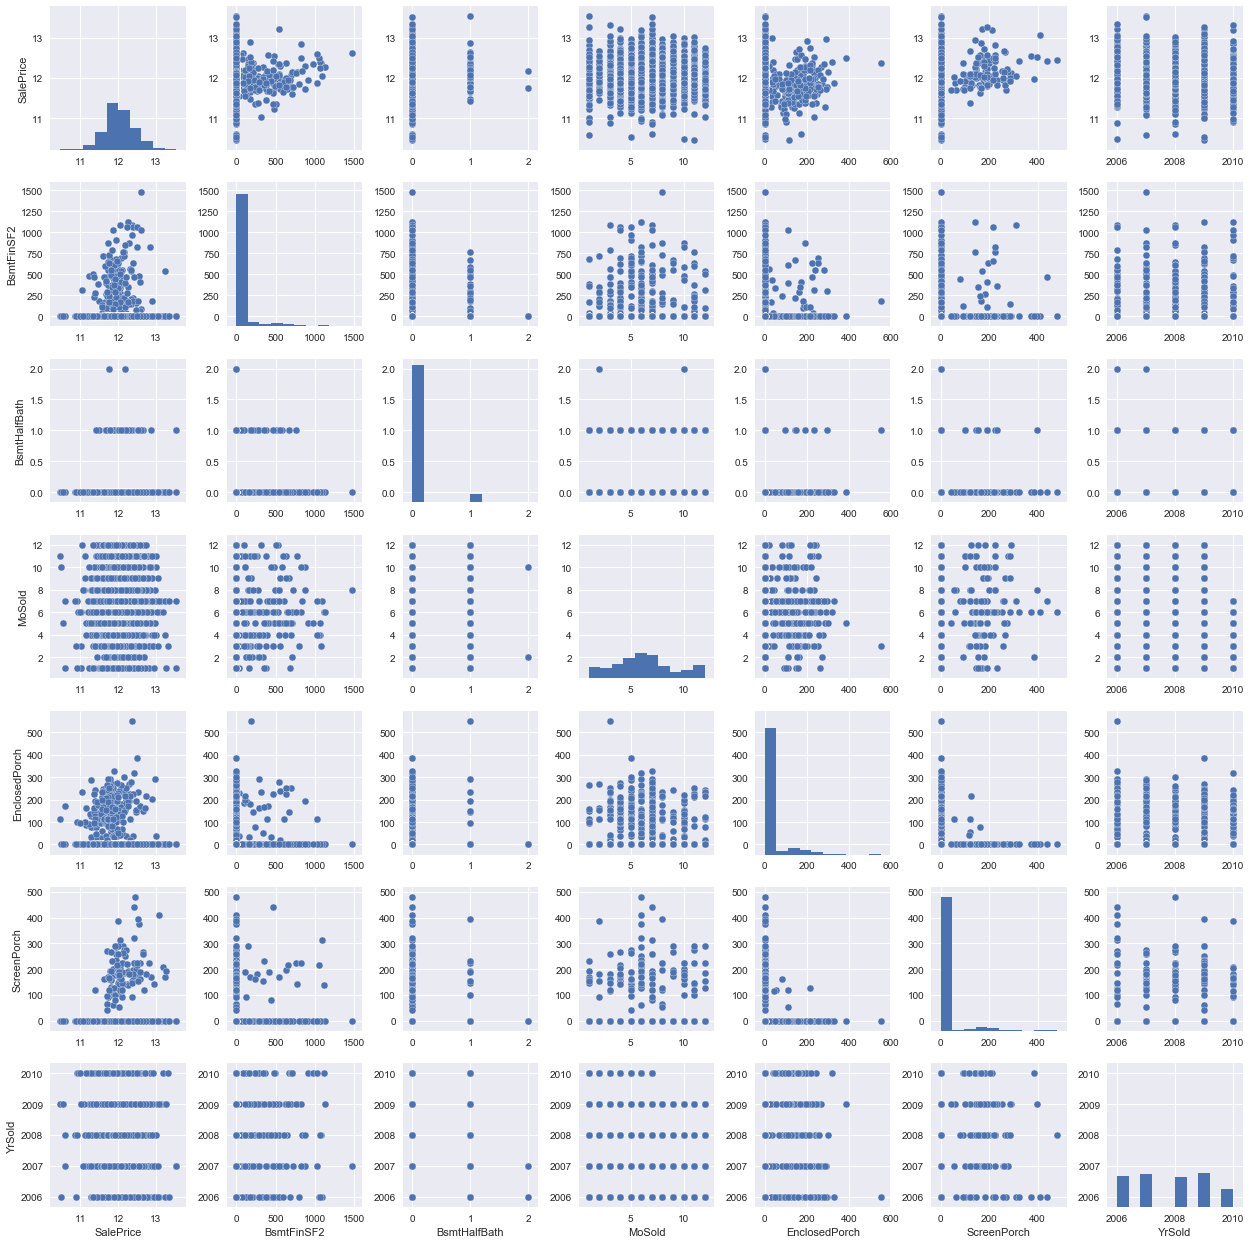

In [152]:
sns.set()
cols = ['SalePrice', 'BsmtFinSF2', 'BsmtHalfBath', 'MoSold', 'EnclosedPorch', 'ScreenPorch', 'YrSold']
fig = sns.pairplot(train_clean[cols], size = 2.5)
plt.show()
fig.savefig('./fig/numerical_dropped.png', bbox_inches='tight')

**< Analysis of Least Significant Features by RF >**
- BsmtFinSF2 / BsmtHalfBath / MoSold -> (Numerical)

**< Analysis of 2nd-least Significant Features by RF >**
- EnclosedPorch / ScreenPorch / YrSold -> (Numerical)

-> No Significant Relationship for linearity : dropped

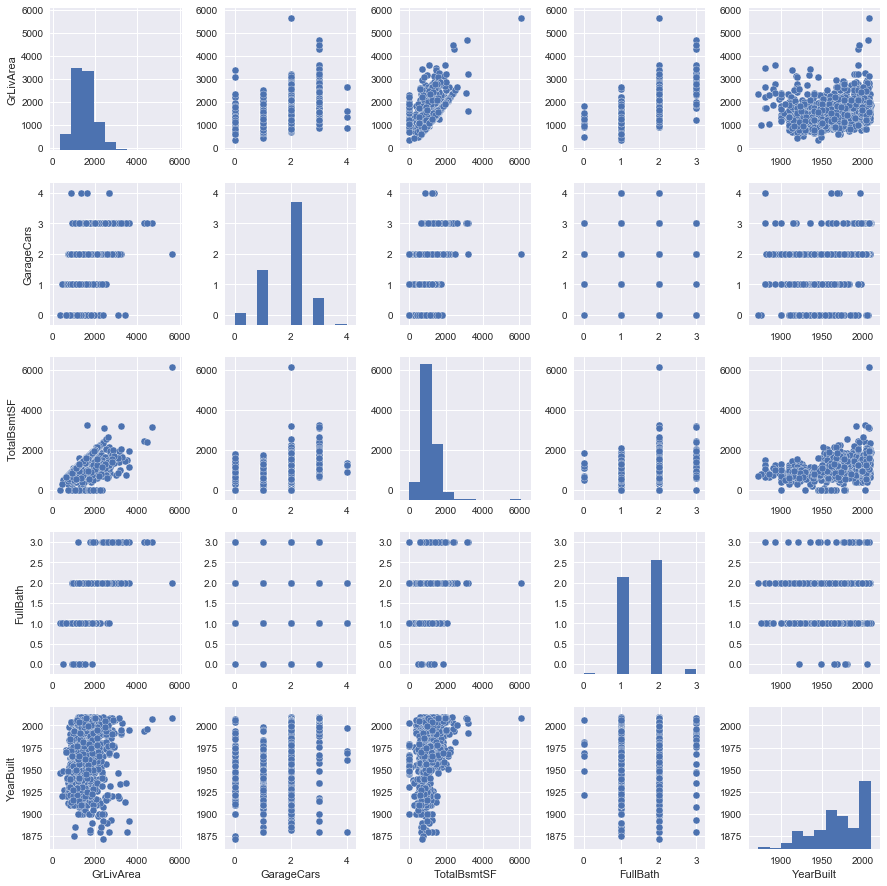

In [153]:
sns.set()
cols = ['GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
fig = sns.pairplot(train_clean[cols], size = 2.5)
plt.show()
fig.savefig('./fig/numerical3.png', bbox_inches='tight')

In [33]:
# Standardizing numeric data --> After all NaN removal
#numeric_features = train.loc[:,['LotFrontage', 'LotArea', 'GrLivArea', 'TotalSF']]
#numeric_features_standardized = (numeric_features - numeric_features.mean())/numeric_features.std()
#ax = sns.pairplot(numeric_features_standardized)

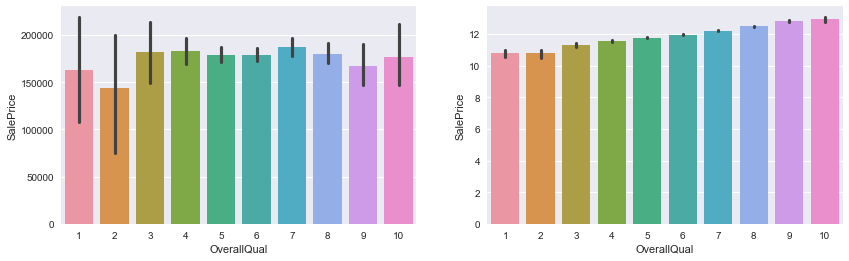

In [154]:
fig, ax = plt.subplots(1, 2, figsize = (14, 4))
sns.barplot(pd.to_numeric(train_clean.OverallQual),SP.SalePrice, ax = ax[0])
sns.barplot(pd.to_numeric(train_clean.OverallQual),train_clean.SalePrice, ax = ax[1])

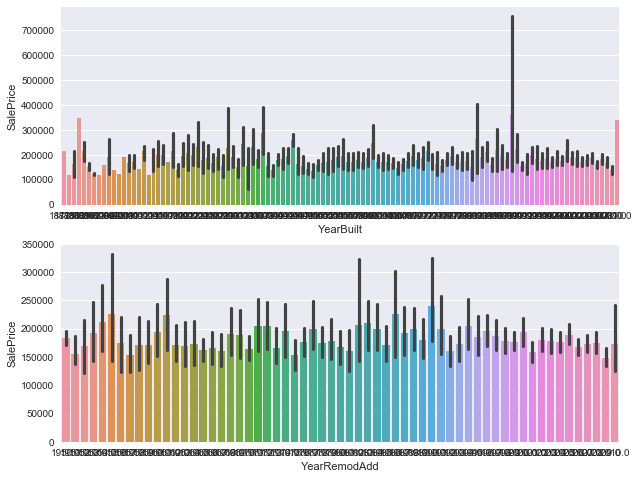

In [155]:
fig, ax = plt.subplots(2, 1, figsize = (10, 8))
sns.barplot(train_clean.YearBuilt,SP.SalePrice, ax = ax[0])
sns.barplot(train_clean.YearRemodAdd,SP.SalePrice, ax = ax[1])
#sns.barplot(train_clean.YearBuilt,train_clean.SalePrice, ax = ax[0])
#sns.barplot(train_clean.YearRemodAdd,train_clean.SalePrice, ax = ax[1])

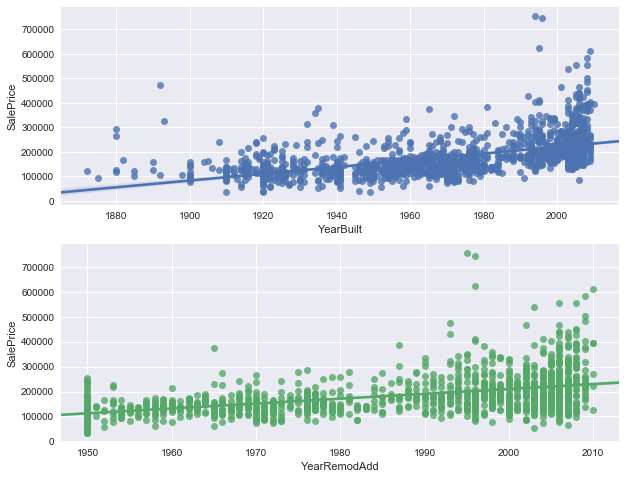

In [156]:
fig, ax = plt.subplots(2, 1, figsize = (10, 8))
sns.regplot(train_clean.YearBuilt,SP.SalePrice, ax = ax[0])
sns.regplot(train_clean.YearRemodAdd,SP.SalePrice, ax = ax[1])

### 5.2 Correlations between Continuous Variables

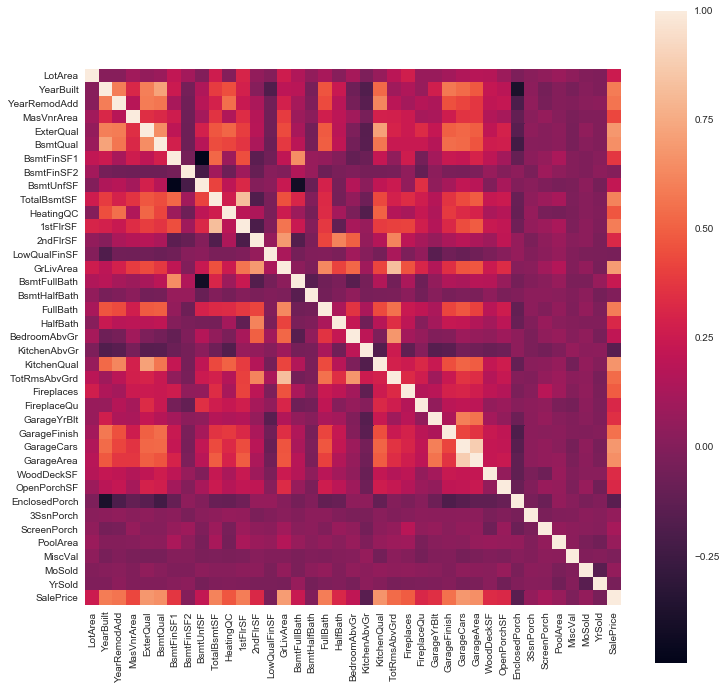

In [157]:
# Numerical Features
corr = train_clean.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, vmax=1, square=True)
#sns.heatmap(corr, vmax=.8, annot=True)

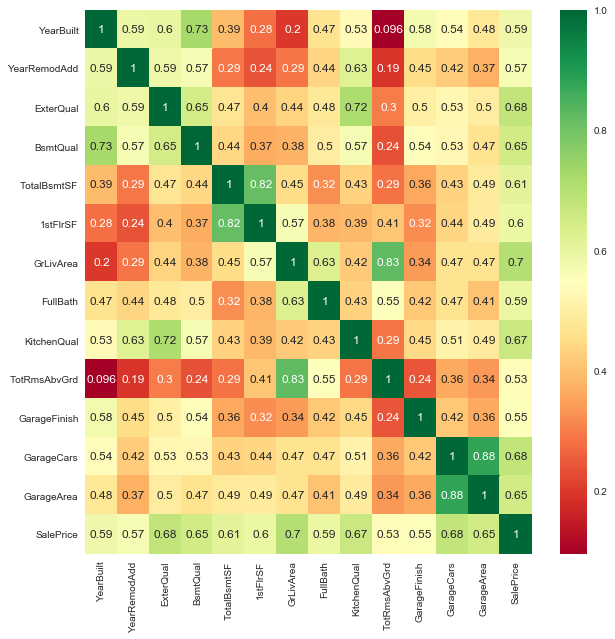

In [158]:
# most correlated features
corrmat = train_clean.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
fig = plt.figure(figsize=(10,10))
g = sns.heatmap(train_clean[top_corr_features].corr(),annot=True,cmap="RdYlGn")
fig.savefig('./fig/heatmap2.png', bbox_inches='tight')

### 5.2 Categorical Feature Analysis

In [159]:
df_categorical = train_clean.select_dtypes(include=['category'])
df_categorical.columns

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterCond',
       'Foundation', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional',
       'GarageType', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'],
      dtype='object')

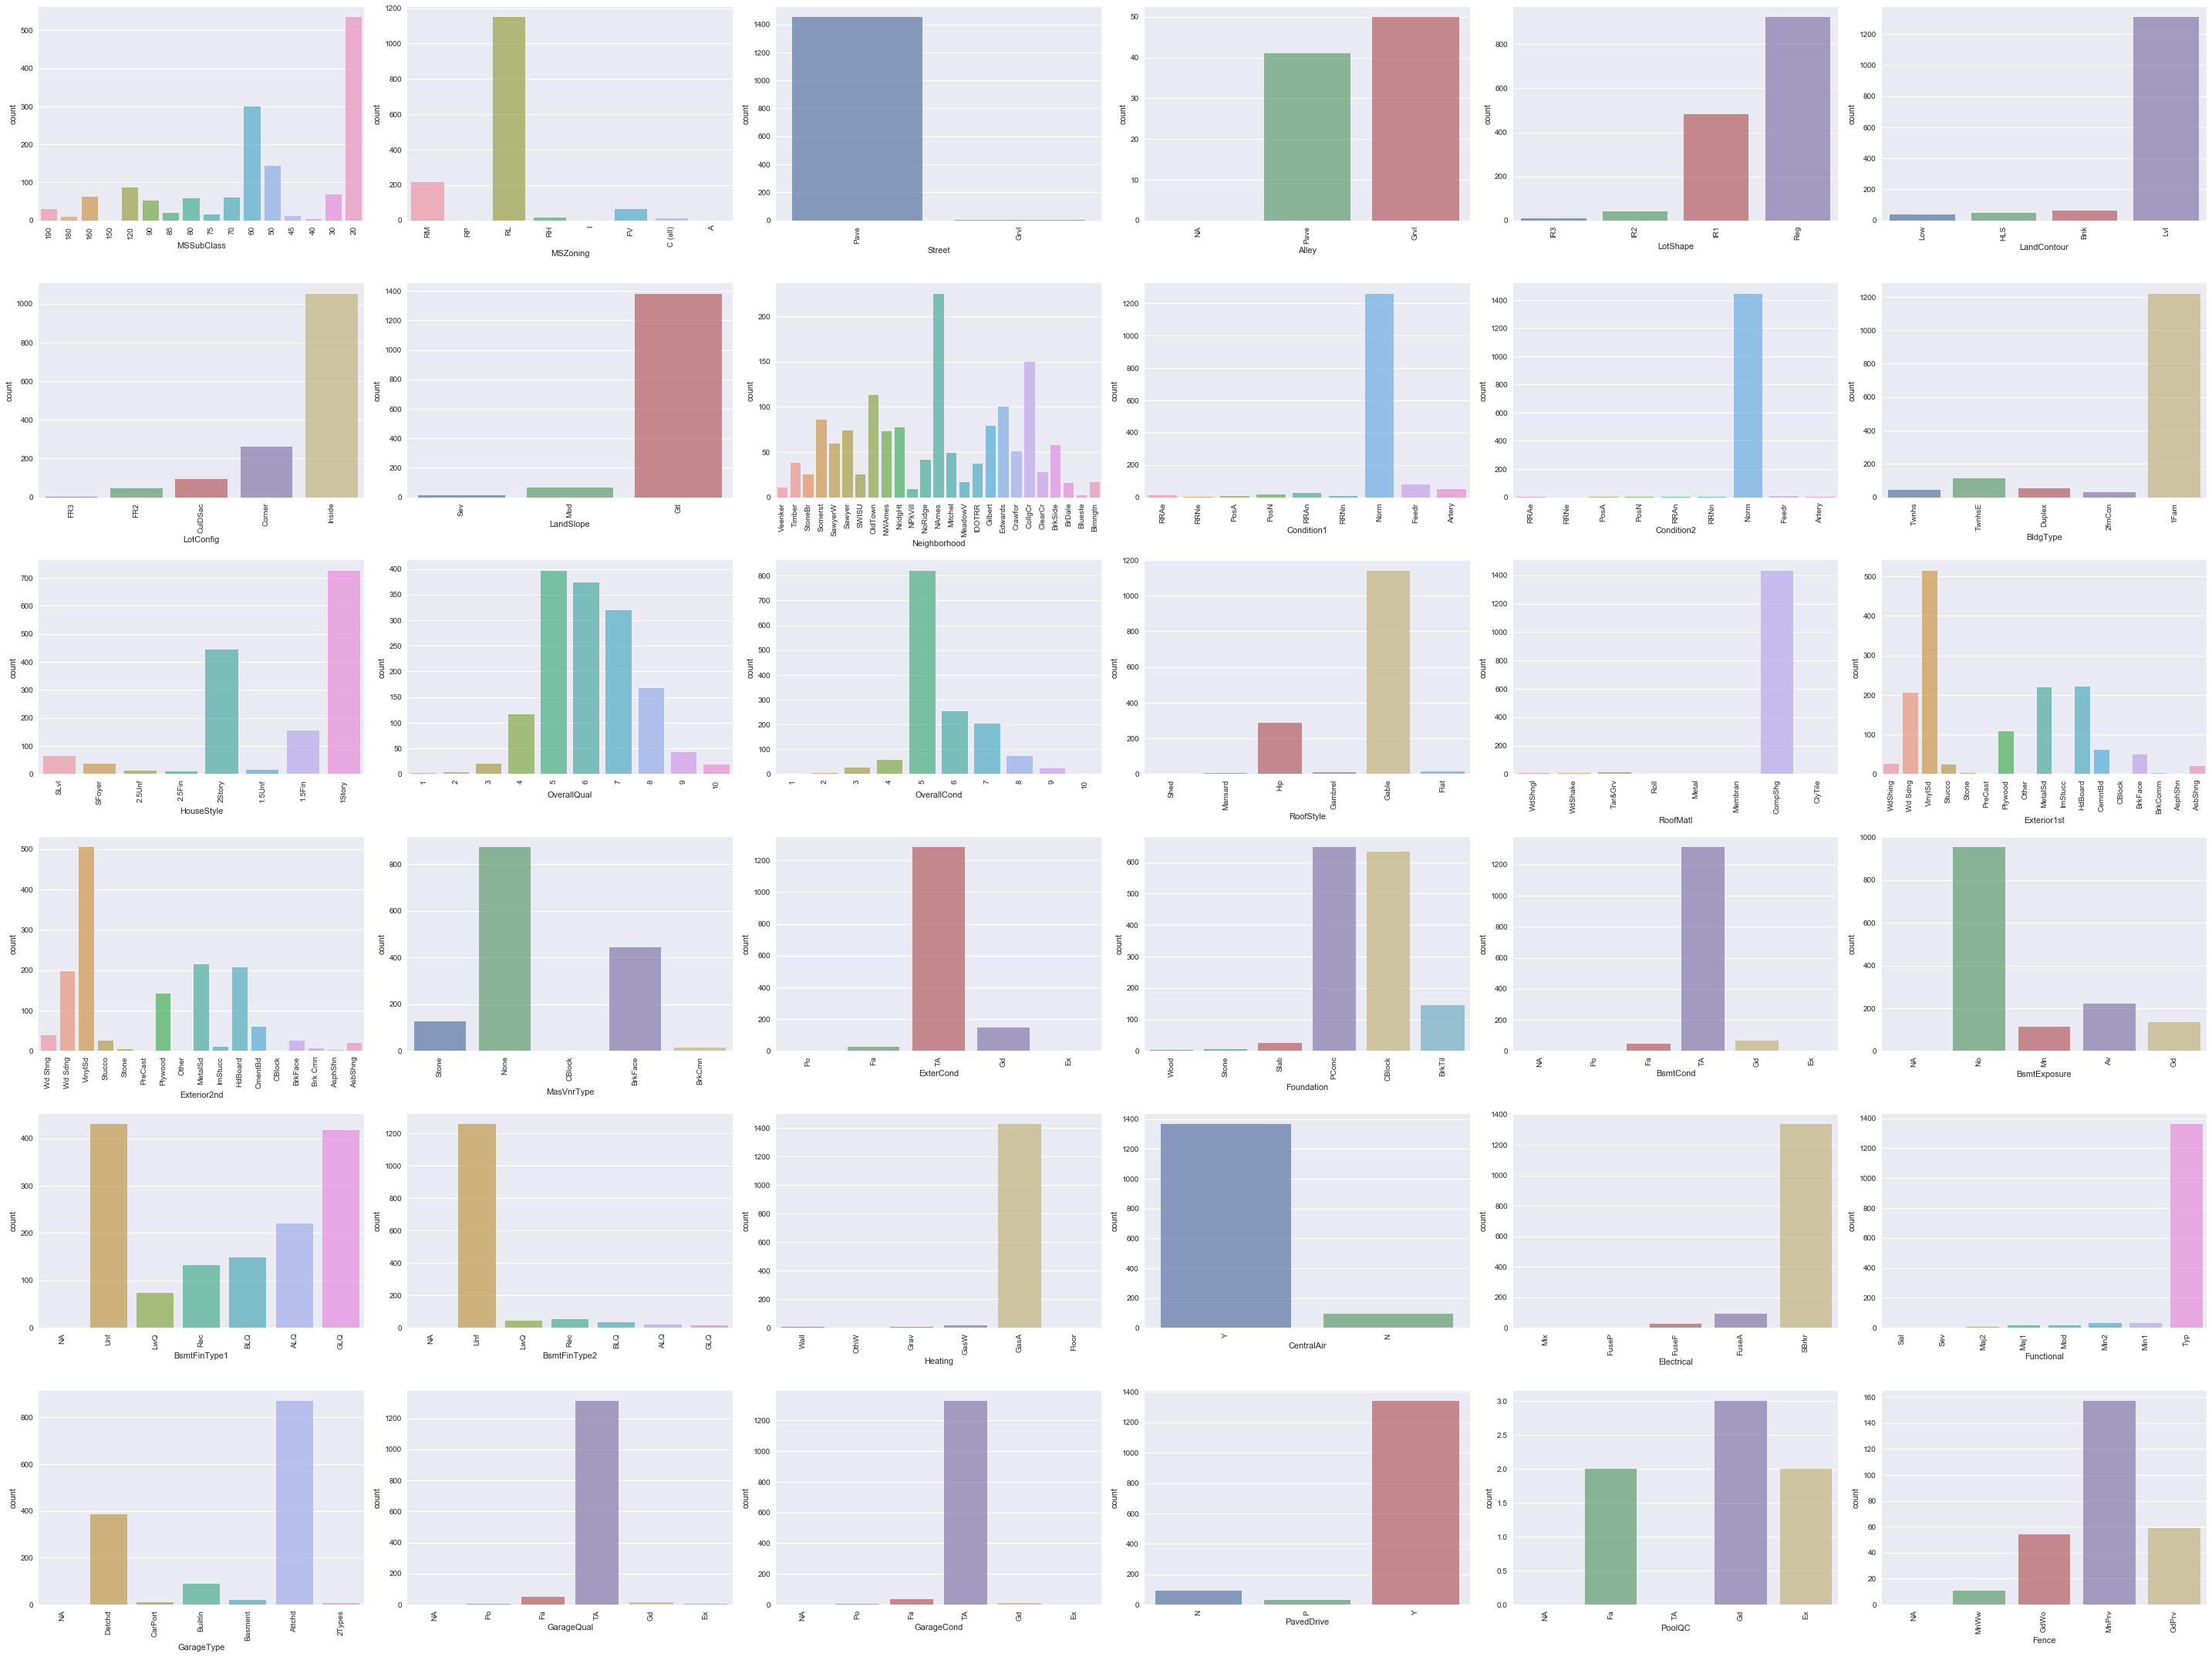

In [160]:
fig, axes = plt.subplots(round(len(df_categorical.columns) / 6), 6, figsize=(40, 30))
#fig, axes = plt.subplots(round(len(df_categorical.columns) / 6), 6, figsize=(12, 30))

for i, ax in enumerate(fig.axes):
    if i < len(df_categorical.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
        sns.countplot(x=df_categorical.columns[i], alpha=0.7, data=df_categorical, ax=ax)

fig.tight_layout()
fig.savefig('./fig/categorical_cnt.png', bbox_inches='tight')  
#plt.close(fig)

**< Analysis of Least Significant Features by RF >**
- Alley -> (C)Gravel vs Paved almost same, No 'No Alley Access'
- ExterCond -> (C)Most are 'TA' (Average/Typical)
- BsmtFinSF2 -> (N)
- Heating -> (C)Most are GasA
- Electrical -> (C)Most are SBrkr (Standard Circuit Breakers)
- BsmtHalfBath -> (N)
- PavedDrive -> (C)Most are Y (Paved)
- Fence -> Difficult to interprete by countplot (Maybe no relationship with SalePrice) -> check
- MiscFeature -> (C)Most have Shed
- MoSold -> (N)

**< Analysis of 2nd-least Significant Features by RF >**
- BsmtFinType2 -> (C)Most are Unfinished
- LandContour  -> (C)Most are Flat/Level
- EnclosedPorch -> (N)
- SaleType -> (C)Most are WD (Warranty Deed - Conventional)
- Functional -> (C)Most are Typical
- LotConfig -> (C)Difficult to interprete by countplot (Maybe no relationship with SalePrice) -> check
- ScreenPorch -> (N)
- YrSold -> (N)
- LandSlope -> (C)Most have Gentle Slope

**< Anlaysis by Countplot Skewness >**
- Street -> (C)Most are Paved
- Condition1 -> (C)Most are Normal
- Condition2 -> (C)Most are Normal
- BldgType ->(C)Most are 1Fam (Single-family Detached)
- RoofMatl -> (C)Most are Standard (Composite) Shingle
- BsmtCond -> (C)Most are Typical
- GarageQual -> (C)Most are Typical
- GarageCond -> (C)Most are Typical

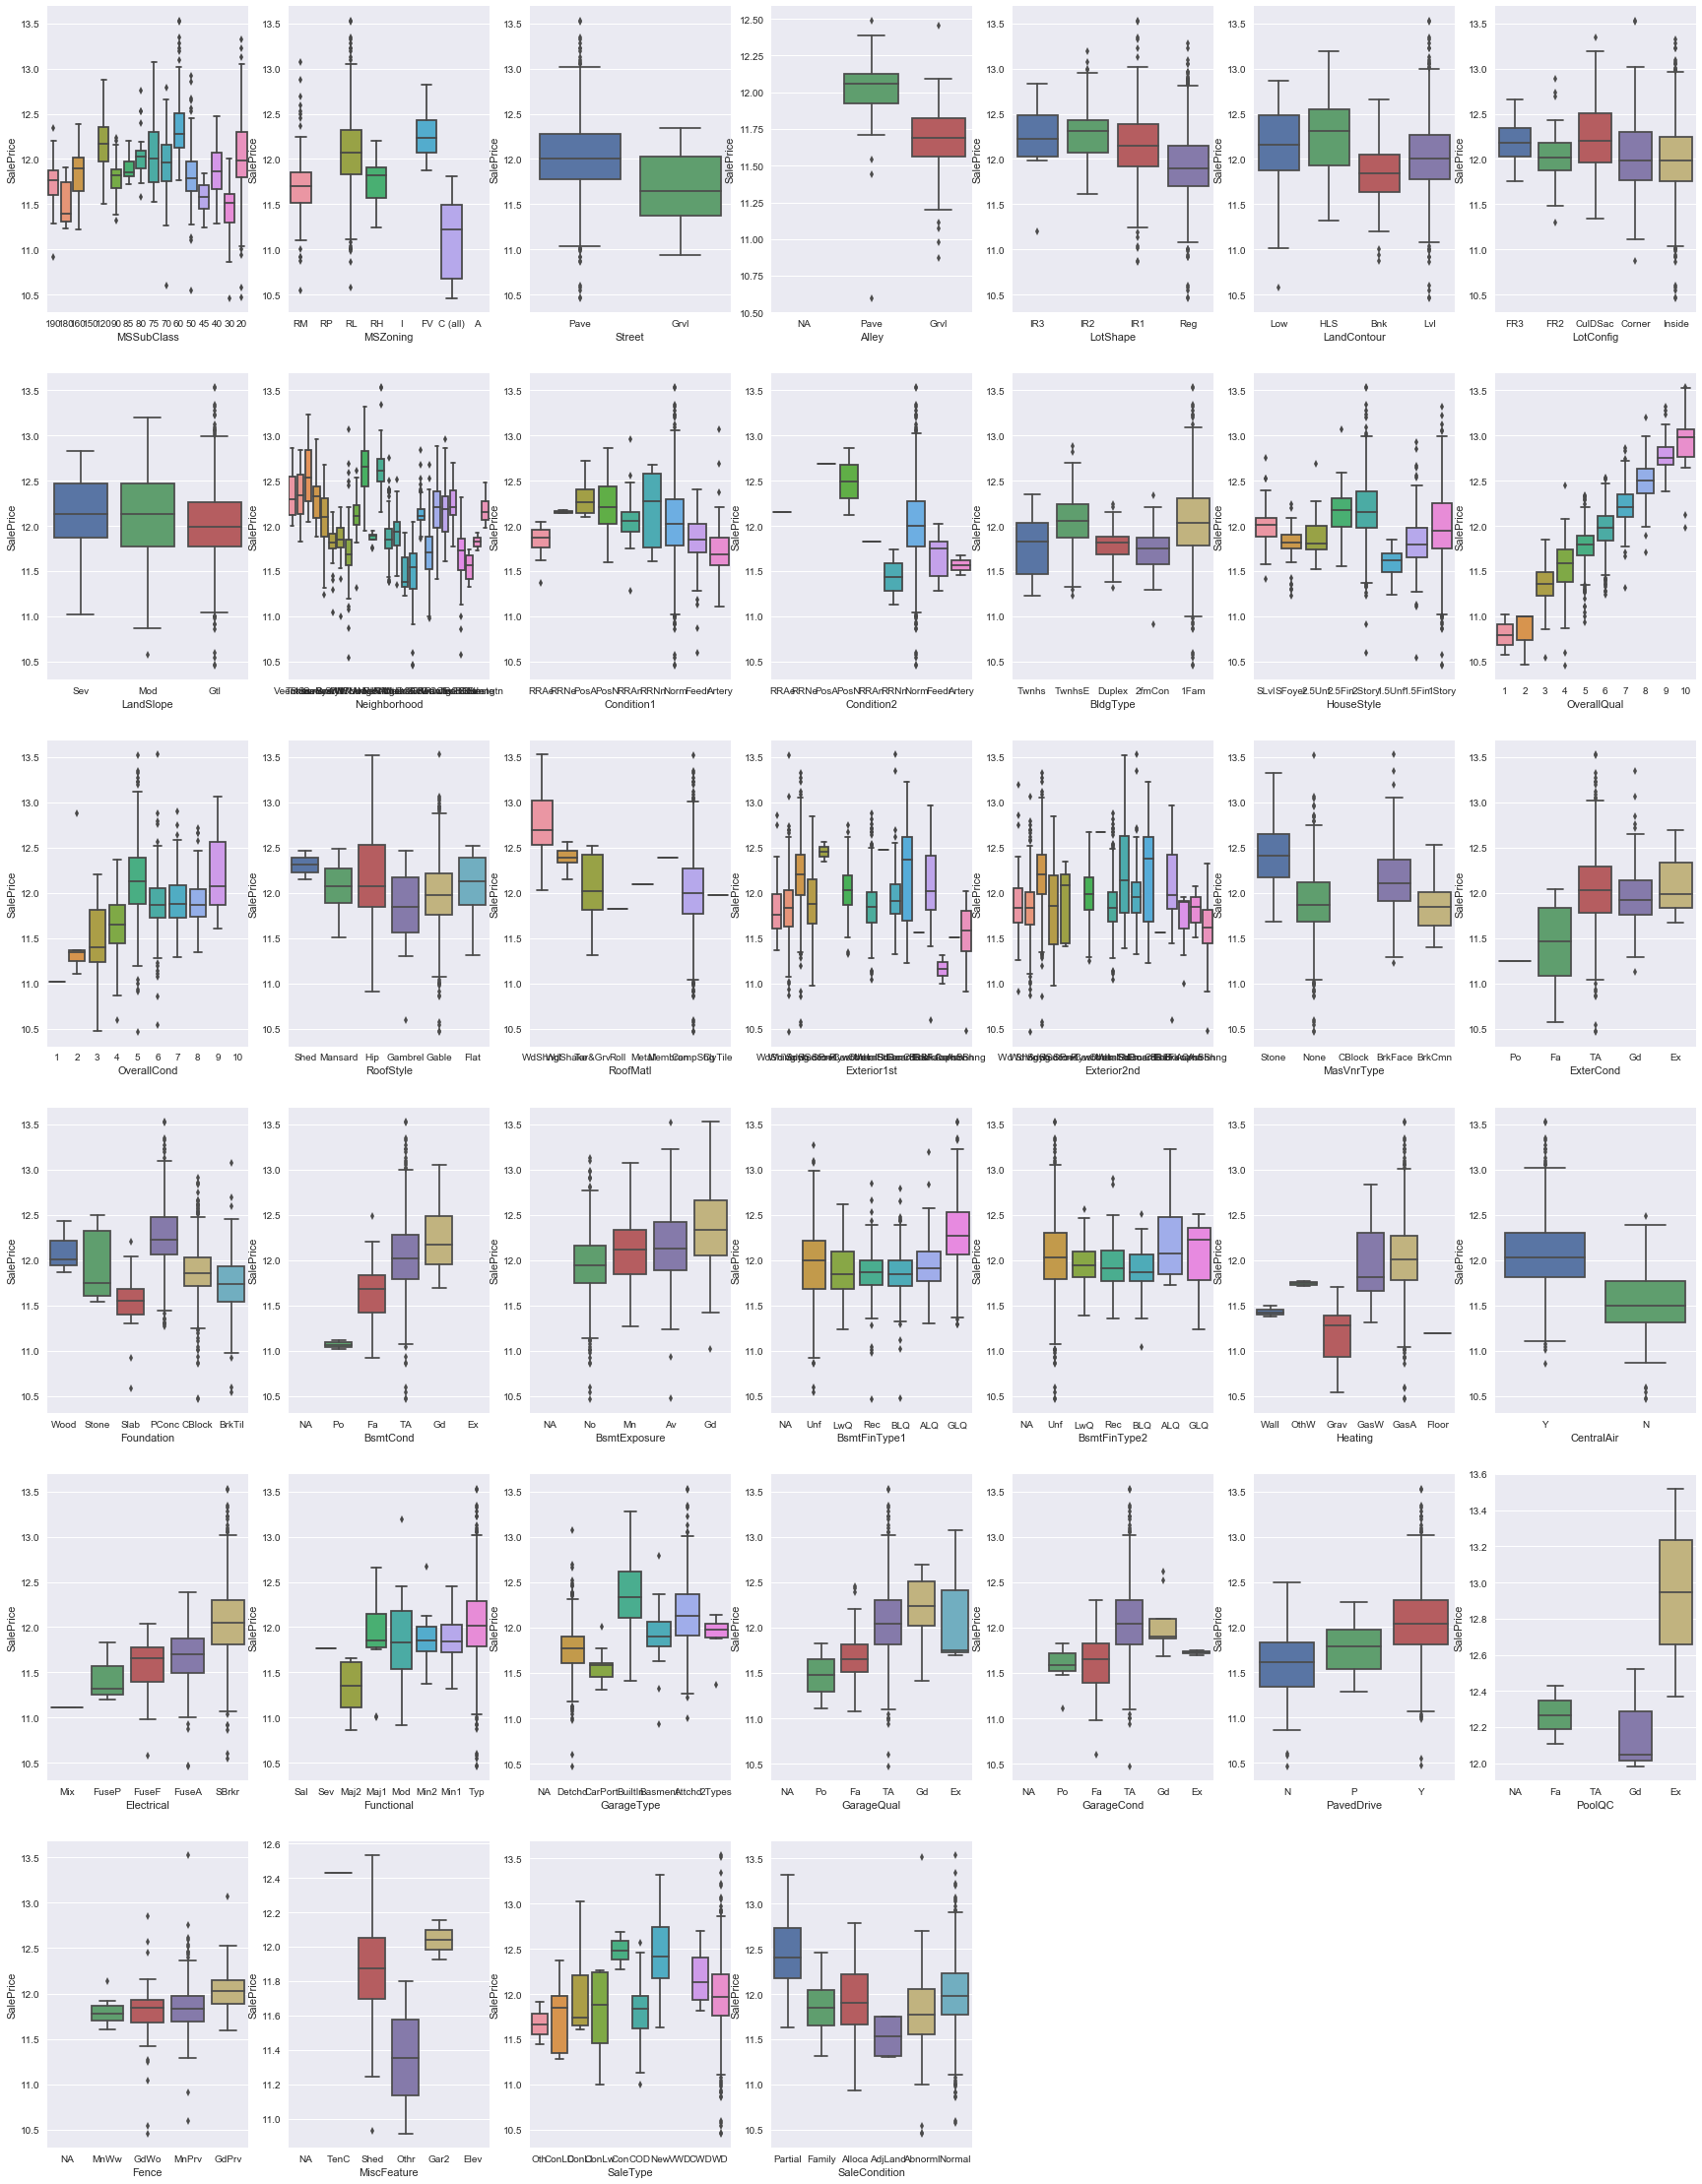

In [161]:
fig = plt.figure(figsize= (30, 40))
for i in range(len(df_categorical.columns)):
    plt.subplot(len(df_categorical.columns)/6, 7, i + 1)
    sns.boxplot(x = list(df_categorical.columns)[i], y = 'SalePrice', data = train_clean)
fig.savefig('./fig/Categorical.png', bbox_inches='tight')

In [172]:
ord_col = ['SalePrice', 'ExterQual', 'BsmtQual', 'KitchenQual', 'GarageFinish', 'FireplaceQu', 'HeatingQC']
df_ord = train_clean[ ord_col]
df_ord['Index'] = df_ord.index
ord_col_bar = df_ord[['SalePrice', 'Index']]



ord_cor['Index'] = ord_cor.index
ord_cor_bar = ord_cor[['SalePrice', 'Index']]
ord_cor_bar.sort_values(by = 'SalePrice', ascending = 0, inplace = True)
plt.subplots(figsize=[12, 9])
sns.barplot(x = 'SalePrice', y = 'Index', data = ord_cor_bar)

TypeError: list indices must be integers or slices, not str

In [132]:
ord_col = ['SalePrice', 'ExterQual', 'BsmtQual', 'KitchenQual', 'GarageFinish', 'FireplaceQu', 'HeatingQC']
train_clean[ ord_col]
ord_col

['SalePrice',
 'ExterQual',
 'BsmtQual',
 'KitchenQual',
 'GarageFinish',
 'FireplaceQu',
 'HeatingQC']

**Neighborhood**

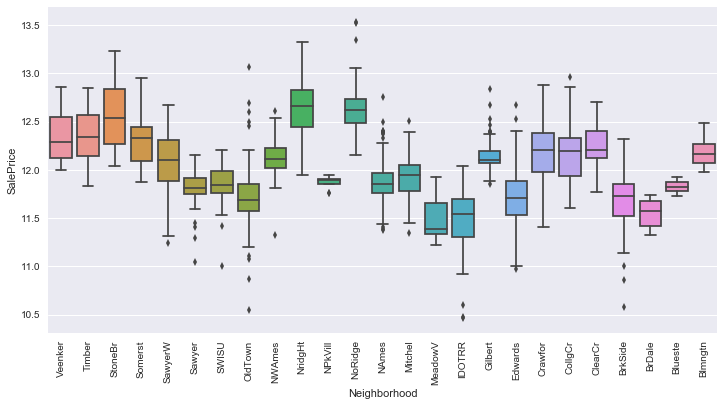

In [82]:
fig = plt.figure(figsize = (12, 6))
sns.boxplot(x = 'Neighborhood', y = 'SalePrice',  data = train_clean)
xt = plt.xticks(rotation=90)
fig.savefig('./fig/neighbor.png', bbox_inches='tight')

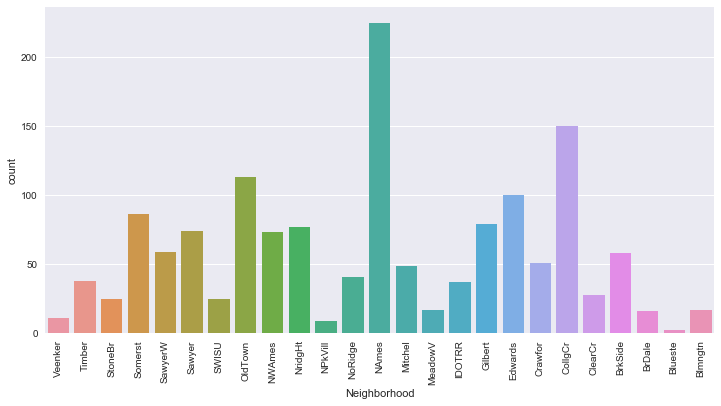

In [83]:
fig = plt.figure(figsize = (12, 6))
sns.countplot(x = 'Neighborhood', data = train_clean)
xt = plt.xticks(rotation=90)
fig.savefig('./fig/neighbor2.png', bbox_inches='tight')

**Housing Price vs Sales**

 - Sale Type & Condition
 - Sales Seasonality

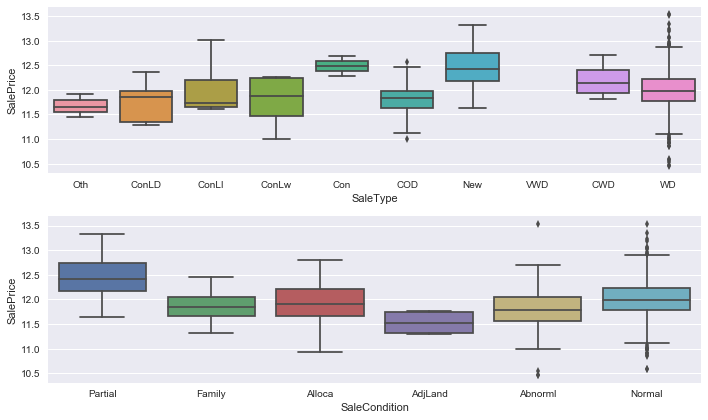

In [84]:
fig, ax = plt.subplots(2, 1, figsize = (10, 6))
sns.boxplot(x = 'SaleType', y = 'SalePrice', data = train_clean, ax = ax[0])
sns.boxplot(x = 'SaleCondition', y = 'SalePrice', data = train_clean, ax = ax[1])
plt.tight_layout()
fig.savefig('./fig/SaleType_Cond.png', bbox_inches='tight')

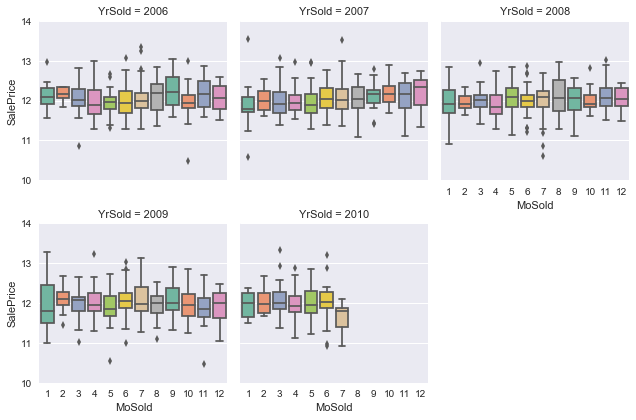

In [85]:
g = sns.FacetGrid(train_clean, col = 'YrSold', col_wrap = 3)
g.map(sns.boxplot, 'MoSold', 'SalePrice', palette='Set2', order = range(1, 13))\
.set(ylim = (10, 14))
plt.tight_layout()
g.savefig('./fig/YrSold.png', bbox_inches='tight')

**Housing Style**

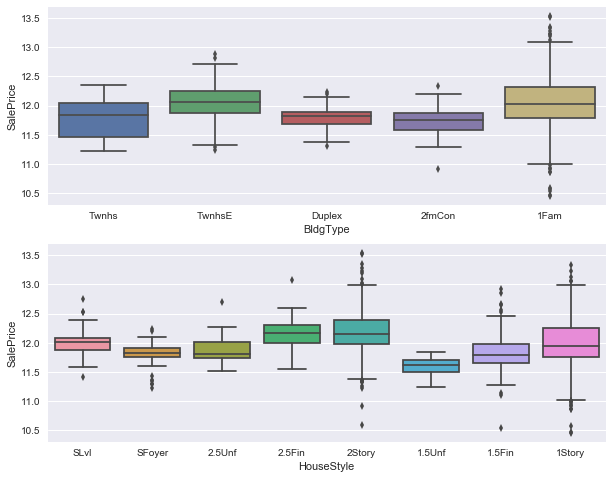

In [86]:
fig, ax = plt.subplots(2, 1, figsize = (10, 8))
sns.boxplot(x = 'BldgType', y = 'SalePrice', data = train_clean, ax = ax[0])
sns.boxplot(x = 'HouseStyle', y = 'SalePrice', data = train_clean, ax = ax[1])
fig.savefig('./fig/BldgType_HouseStyle.png', bbox_inches='tight')

**Housing Condition**

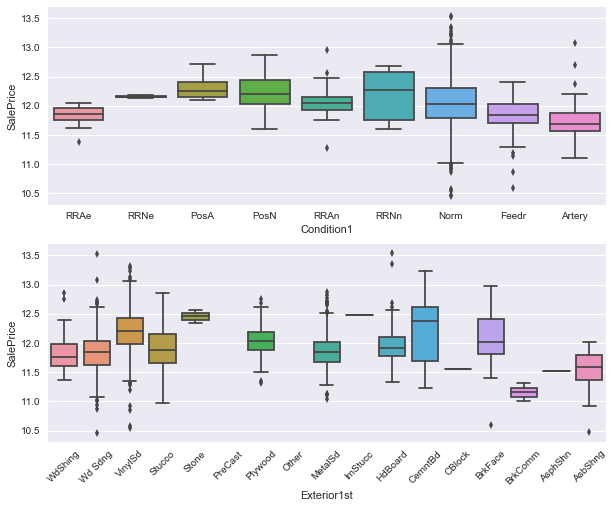

In [87]:
fig, ax = plt.subplots(2, 1, figsize = (10, 8))
sns.boxplot(x = 'Condition1', y = 'SalePrice', data = train_clean, ax = ax[0])
sns.boxplot(x = 'Exterior1st', y = 'SalePrice', data = train_clean, ax = ax[1])
x = plt.xticks(rotation = 45)
plt.show()
fig.savefig('./fig/Cond_Ext1st.png', bbox_inches='tight')

**Basement Conditions**

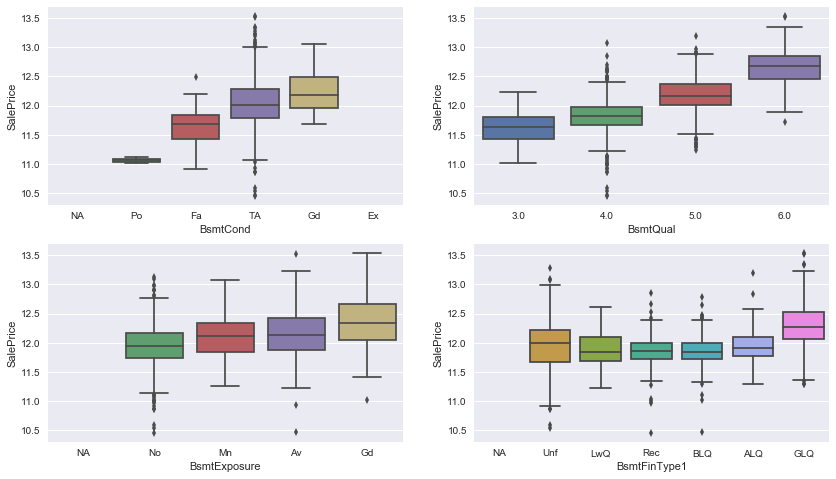

In [88]:
fig, ax = plt.subplots(2, 2, figsize = (14, 8))
sns.boxplot('BsmtCond', 'SalePrice', data = train_clean, ax = ax[0, 0])
sns.boxplot('BsmtQual', 'SalePrice', data = train_clean, ax = ax[0, 1])
sns.boxplot('BsmtExposure', 'SalePrice', data = train_clean, ax = ax[1, 0])
sns.boxplot('BsmtFinType1', 'SalePrice', data = train_clean, ax = ax[1, 1])
fig.savefig('./fig/Bsmt.png', bbox_inches='tight')

**Home Functionality**

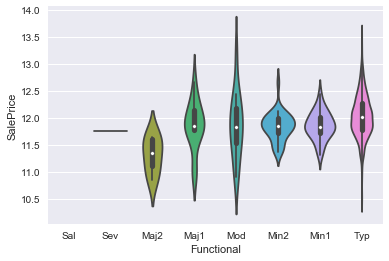

In [48]:
sns.violinplot('Functional', 'SalePrice', data = train_clean)

## 6 Outlier Analysis

## Future reference

### F.1 Splitting to features and labels and deleting variables I don't need **

In [49]:
# cf) dropna, fillna
# Spliting to features and lables and deleting variable I don't need
#train_labels = train.pop('SalePrice')

features = pd.concat([train, test], keys=['train', 'test'])

# I decided to get rid of features that have more than half of missing information or do not correlate to SalePrice
features.drop(['Utilities', 'RoofMatl', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'Heating', 'LowQualFinSF',
               'BsmtFullBath', 'BsmtHalfBath', 'Functional', 'GarageYrBlt', 'GarageArea', 'GarageCond', 'WoodDeckSF',
               'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal'],
              axis=1, inplace=True)

NameError: name 'train' is not defined

### F.2 Filling NAs and converting features

In [ ]:
# MSSubClass as str
features['MSSubClass'] = features['MSSubClass'].astype(str)

# MSZoning NA in pred. filling with most popular values
features['MSZoning'] = features['MSZoning'].fillna(features['MSZoning'].mode()[0])

# LotFrontage  NA in all. I suppose NA means 0
features['LotFrontage'] = features['LotFrontage'].fillna(features['LotFrontage'].mean())

# Alley  NA in all. NA means no access
features['Alley'] = features['Alley'].fillna('NOACCESS')

# Converting OverallCond to str
features.OverallCond = features.OverallCond.astype(str)

# MasVnrType NA in all. filling with most popular values
features['MasVnrType'] = features['MasVnrType'].fillna(features['MasVnrType'].mode()[0])

# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2
# NA in all. NA means No basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('NoBSMT')

# TotalBsmtSF  NA in pred. I suppose NA means 0
features['TotalBsmtSF'] = features['TotalBsmtSF'].fillna(0)

# Electrical NA in pred. filling with most popular values
features['Electrical'] = features['Electrical'].fillna(features['Electrical'].mode()[0])

# KitchenAbvGr to categorical
features['KitchenAbvGr'] = features['KitchenAbvGr'].astype(str)

# KitchenQual NA in pred. filling with most popular values
features['KitchenQual'] = features['KitchenQual'].fillna(features['KitchenQual'].mode()[0])

# FireplaceQu  NA in all. NA means No Fireplace
features['FireplaceQu'] = features['FireplaceQu'].fillna('NoFP')

# GarageType, GarageFinish, GarageQual  NA in all. NA means No Garage
for col in ('GarageType', 'GarageFinish', 'GarageQual'):
    features[col] = features[col].fillna('NoGRG')

# GarageCars  NA in pred. I suppose NA means 0
features['GarageCars'] = features['GarageCars'].fillna(0.0)

# SaleType NA in pred. filling with most popular values
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

# Year and Month to categorical
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

# Adding total sqfootage feature and removing Basement, 1st and 2nd floor features
features['TotalSF'] = features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']
features.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'], axis=1, inplace=True)

- heatmap --> Convert 'OverallQual' to Numeric and Check again !!! 

In [ ]:
# most correlated features
corrmat = house.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(house[top_corr_features].corr(),annot=True,cmap="RdYlGn")